In [1]:
#import sys
#!{sys.executable} -m pip install opencv-python

In [2]:
## Load libraries
import sys
from os import listdir
import os
from matplotlib import image
from PIL import Image
import numpy as np
from numpy import asarray
#import cv2
from matplotlib import pyplot
import tensorflow as tf
from math import ceil
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.constraints import maxnorm
from keras.layers.normalization import BatchNormalization
from keras.optimizers import SGD
from keras.optimizers import Adadelta
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils

Using TensorFlow backend.


In [3]:
def loadimages(img_size):
    # load all images in a directory
    direc = os.getcwd() + '\\img\\'
    numdir = len(listdir(direc))

    img_resized_data = []
    X = []
    Y = []
    i = 0

    for dirname in listdir(direc):
        i+=1
        for filename in listdir(direc + '\\' + dirname):
            # load image
            img = Image.open(direc + '\\' + dirname + '\\' + filename)

            # resizing the image for processing them in the covnet
            img = img.resize((img_size, img_size))

            # final step-forming the training data list with numpy array of the images 
            img_resized_data.append(np.array(img)) 
            Y.append(np.array(i-1))

    X = np.array(img_resized_data)
    Y = np.array(Y)

    print('X containing {} sample of images with size {}x{}x{}.\nY containing {} labels of {} different classes.\n'.format(X.shape[0],X.shape[1],X.shape[2],X.shape[3],Y.shape[0],np.max(Y)+1))
    
    return X,Y

In [5]:
def prepdata(X,Y):
    
    Y1= []
    y_train = []
    y_test = []

    # one hot encode outputs
    Y1 = np_utils.to_categorical(Y)
    num_classes = Y1.shape[1]

    #--- Splitting the dataset into the Training set and Test set
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, Y1, test_size = 0.25)

    X_train = X_train.astype('float32')
    X_test = X_test.astype('float32')
    X_train = X_train/255
    X_test = X_test/255
    print('There are {} trainingsamples and {} testsamples'.format(X_train.shape[0], X_test.shape[0]))
    print('Sample shape is: {}'.format(X_train.shape))
    print('The number of different labels is {}.'. format(num_classes))

    print('In the testset there are {} samples with label 1.'.format(np.sum(y_test[:,0] == 1)))
    print('In the testset there are {} samples with label 2.'.format(np.sum(y_test[:,1] == 1)))
    print('In the testset there are {} samples with label 3.\n'.format(np.sum(y_test[:,2] == 1)))
    
    return X_train, X_test, y_train, y_test, num_classes

In [6]:
def prep_imagegenerator(X_train, y_train,batch_size):
    ## Image Augmentation
    image_gen = ImageDataGenerator(#rescale=1./255,
                                   rotation_range=90,
                                   height_shift_range=0.25,
                                   shear_range=0.25,
                                   zoom_range=[0.8, 1.4],
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   fill_mode='reflect')

    image_gen.fit(X_train)

    train_data = image_gen.flow(X_train, y_train,batch_size=batch_size)
    
    return train_data

In [7]:
def makemodel(img_size, numclasses):
    
    ## create model
    model = Sequential()
    model.add(Conv2D(64, (3, 3), input_shape=(img_size,img_size,3), padding='same', activation='relu', kernel_constraint=maxnorm(3)))
    model.add(Dropout(0.2))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(Dropout(0.2))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Dropout(0.2))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dropout(0.2))
    model.add(Dense(512, activation='relu', kernel_constraint=maxnorm(3)))
    model.add(Dropout(0.2))
    model.add(Dense(256, activation='relu', kernel_constraint=maxnorm(3)))
    model.add(Dropout(0.2))
    model.add(Dense(num_classes, activation='softmax'))

    ## summarize model
    #model.summary()
    
    return model

In [55]:
def compile_model(model, epochs, batch_size, lrate, moment, decay):
    ## Compile model
    epochs =500
    batch_size = batch_size
    lrate = 0.01
    moment = 0.95
    decay = 1e-4
    sgd = SGD(lr=1.0, momentum=moment, decay=decay, nesterov=False)
    Ada = Adadelta(lr=1.0, rho=0.95, epsilon=None, decay=0.0)
    model.compile(loss='categorical_crossentropy', optimizer=Ada, metrics=['accuracy'])
    print(model.summary())
    
    return model

In [56]:
def fit_model(model):
    ## Fit the model
    history = model.fit_generator(train_data,
                              steps_per_epoch = ceil(len(X_train[0]) / batch_size),
                              epochs = epochs,
                              validation_data=(X_test, y_test),
                              initial_epoch=0,
                              verbose = 2)
    
    return history

In [57]:
def show_results(history):
    ## Final evaluation of the model
    _, train_acc = model.evaluate(X_train, y_train, verbose=0)
    _, test_acc = model.evaluate(X_test, y_test, verbose=0)
    print("Accuracy: %.2f%%" % (test_acc*100))

    # plot loss during training
    pyplot.subplot(211)
    pyplot.title('Loss')
    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='test')
    pyplot.legend()
    #plot accuracy during training
    pyplot.subplot(212)
    pyplot.title('Accuracy')
    pyplot.plot(history.history['acc'], label='train')
    pyplot.plot(history.history['val_acc'], label='test')
    pyplot.legend()
    pyplot.show()

    # save plot to file
    #filename = sys.argv[0].split('/')[-1]
    #pyplot.savefig(filename + '_plot.png')
    #pyplot.close()

    # save model
    #model.save(filename + '_model.h5')

In [58]:
## Evaluate results / show wrongly predicted images

def predictions(X_test):
    
    ## Get predictions
    y_predict_2 = model.predict(X_test)
    y_predict = model.predict_classes(X_test).reshape(-1,1)
    y_right = y_predict
    y_predict = np_utils.to_categorical(y_predict)

    ## Calculate numberr of wrongly classified samples
    l1, l2, l3, l1f, l2f,l3f = 0,0,0,0,0,0

    for i in range(len(y_test)):
        if y_test[i,0] == True:
            l1 += 1
            if y_predict[i,0] == False:
                l1f += 1
        if y_test[i,1] == True:
            l2 += 1
            if y_predict[i,1] == False:
                l2f += 1
        if y_test[i,2] == True:
            l3 += 1
            if y_predict[i,2] == False:
                l3f += 1
    
    print('{:2.0f} percent of label 1 predicted wrong.'.format(l1f/l1*100))
    print('{:2.0f} percent of label 2 predicted wrong.'.format(l2f/l2*100))
    print('{:2.0f} percent of label 3 predicted wrong.'.format(l3f/l3*100))

    ## Show the images of wrongly classified samples
    for i in range(len(y_predict)):
        if (y_predict[i]==y_test[i]).all() == False:
            y_right[i] = (y_predict[i]==y_test[i]).all()
            pyplot.figure(figsize=(2,2))
            pyplot.imshow(X_test[i].reshape(img_size,img_size,-1))
            pyplot.show()
            if y_right[i] == True:
                right = 'RIGHT. '
            else:
                right = 'WRONG. '
            print('{}Predicted value: {}. Label value: {}'.format(right,y_predict[i],y_test[i]))

    return y_predict

In [59]:
### MAIN ###

# model parameters
img_size = 64
epochs = 500
batch_size = 45
lrate = 0.1
moment = 0.98
decay = 1e-4

# machine learning
X,Y = loadimages(img_size)
#X = adjust_colors(X)
X_train, X_test, y_train, y_test, num_classes = prepdata(X,Y)
train_data = prep_imagegenerator(X_train, y_train,batch_size)
model = makemodel(img_size, num_classes)
model = compile_model(model, epochs, batch_size, lrate, moment, decay)
history = fit_model(model)

X containing 120 sample of images with size 64x64x3.
Y containing 120 labels of 3 different classes.

There are 90 trainingsamples and 30 testsamples
Sample shape is: (90, 64, 64, 3)
The number of different labels is 3.
In the testset there are 10 samples with label 1.
In the testset there are 7 samples with label 2.
In the testset there are 13 samples with label 3.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 64, 64, 64)        1792      
_________________________________________________________________
dropout_19 (Dropout)         (None, 64, 64, 64)        0         
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 32, 32, 128)       73856     
____________________________________

Epoch 65/500
 - 0s - loss: 0.9789 - acc: 0.5444 - val_loss: 0.9858 - val_acc: 0.5000
Epoch 66/500
 - 0s - loss: 0.9020 - acc: 0.6111 - val_loss: 0.9437 - val_acc: 0.6000
Epoch 67/500
 - 0s - loss: 0.9473 - acc: 0.5111 - val_loss: 1.1440 - val_acc: 0.3000
Epoch 68/500
 - 0s - loss: 1.1945 - acc: 0.3889 - val_loss: 1.0154 - val_acc: 0.7333
Epoch 69/500
 - 0s - loss: 0.9633 - acc: 0.5778 - val_loss: 0.9587 - val_acc: 0.7333
Epoch 70/500
 - 0s - loss: 0.9305 - acc: 0.5778 - val_loss: 0.9190 - val_acc: 0.7667
Epoch 71/500
 - 0s - loss: 0.8860 - acc: 0.6444 - val_loss: 0.9108 - val_acc: 0.7333
Epoch 72/500
 - 0s - loss: 1.0803 - acc: 0.5111 - val_loss: 1.0118 - val_acc: 0.6000
Epoch 73/500
 - 0s - loss: 0.9503 - acc: 0.5667 - val_loss: 0.9179 - val_acc: 0.7333
Epoch 74/500
 - 0s - loss: 0.9908 - acc: 0.4889 - val_loss: 1.1582 - val_acc: 0.3000
Epoch 75/500
 - 0s - loss: 1.1701 - acc: 0.4556 - val_loss: 0.9817 - val_acc: 0.7333
Epoch 76/500
 - 0s - loss: 0.9394 - acc: 0.5778 - val_loss: 0.975

Epoch 161/500
 - 1s - loss: 0.6461 - acc: 0.7222 - val_loss: 0.6928 - val_acc: 0.8333
Epoch 162/500
 - 1s - loss: 0.5881 - acc: 0.7778 - val_loss: 0.6268 - val_acc: 0.8667
Epoch 163/500
 - 0s - loss: 0.5904 - acc: 0.7556 - val_loss: 0.7932 - val_acc: 0.6000
Epoch 164/500
 - 1s - loss: 0.6821 - acc: 0.7222 - val_loss: 0.7786 - val_acc: 0.5667
Epoch 165/500
 - 1s - loss: 0.7118 - acc: 0.6444 - val_loss: 0.8877 - val_acc: 0.5667
Epoch 166/500
 - 0s - loss: 0.7269 - acc: 0.6222 - val_loss: 0.7480 - val_acc: 0.7333
Epoch 167/500
 - 1s - loss: 0.5852 - acc: 0.7333 - val_loss: 0.5683 - val_acc: 0.9000
Epoch 168/500
 - 1s - loss: 0.5994 - acc: 0.7444 - val_loss: 0.6299 - val_acc: 0.7667
Epoch 169/500
 - 0s - loss: 0.5344 - acc: 0.7444 - val_loss: 0.6424 - val_acc: 0.7667
Epoch 170/500
 - 1s - loss: 0.5814 - acc: 0.7444 - val_loss: 0.6961 - val_acc: 0.8333
Epoch 171/500
 - 1s - loss: 0.7481 - acc: 0.6889 - val_loss: 0.8322 - val_acc: 0.6333
Epoch 172/500
 - 1s - loss: 0.8949 - acc: 0.5889 - val

Epoch 257/500
 - 0s - loss: 0.3796 - acc: 0.8000 - val_loss: 0.4603 - val_acc: 0.7667
Epoch 258/500
 - 0s - loss: 0.3293 - acc: 0.8667 - val_loss: 0.4914 - val_acc: 0.7667
Epoch 259/500
 - 0s - loss: 0.2989 - acc: 0.8556 - val_loss: 0.5055 - val_acc: 0.7333
Epoch 260/500
 - 1s - loss: 0.2914 - acc: 0.8889 - val_loss: 0.3800 - val_acc: 0.8333
Epoch 261/500
 - 0s - loss: 0.4778 - acc: 0.7889 - val_loss: 0.7607 - val_acc: 0.7333
Epoch 262/500
 - 0s - loss: 0.3896 - acc: 0.7667 - val_loss: 0.3130 - val_acc: 0.9000
Epoch 263/500
 - 1s - loss: 0.2471 - acc: 0.9000 - val_loss: 0.3274 - val_acc: 0.9000
Epoch 264/500
 - 0s - loss: 0.3585 - acc: 0.8000 - val_loss: 0.6391 - val_acc: 0.7667
Epoch 265/500
 - 0s - loss: 0.4772 - acc: 0.8000 - val_loss: 0.3573 - val_acc: 0.8667
Epoch 266/500
 - 0s - loss: 0.3320 - acc: 0.8556 - val_loss: 0.3796 - val_acc: 0.8667
Epoch 267/500
 - 0s - loss: 0.3457 - acc: 0.8111 - val_loss: 0.4711 - val_acc: 0.8333
Epoch 268/500
 - 0s - loss: 0.3757 - acc: 0.8556 - val

Epoch 353/500
 - 1s - loss: 0.5112 - acc: 0.8222 - val_loss: 0.4323 - val_acc: 0.8667
Epoch 354/500
 - 1s - loss: 0.2205 - acc: 0.9222 - val_loss: 0.3903 - val_acc: 0.9000
Epoch 355/500
 - 1s - loss: 0.2834 - acc: 0.8556 - val_loss: 0.2532 - val_acc: 0.9000
Epoch 356/500
 - 1s - loss: 0.2304 - acc: 0.9111 - val_loss: 0.3812 - val_acc: 0.9000
Epoch 357/500
 - 1s - loss: 0.2304 - acc: 0.9111 - val_loss: 0.2924 - val_acc: 0.9333
Epoch 358/500
 - 1s - loss: 0.1257 - acc: 0.9556 - val_loss: 0.3984 - val_acc: 0.8333
Epoch 359/500
 - 0s - loss: 0.2272 - acc: 0.9111 - val_loss: 0.3155 - val_acc: 0.9000
Epoch 360/500
 - 1s - loss: 0.1899 - acc: 0.9333 - val_loss: 0.3763 - val_acc: 0.9333
Epoch 361/500
 - 0s - loss: 0.1546 - acc: 0.9333 - val_loss: 0.4291 - val_acc: 0.8000
Epoch 362/500
 - 1s - loss: 0.4382 - acc: 0.7667 - val_loss: 0.2627 - val_acc: 0.9000
Epoch 363/500
 - 1s - loss: 0.1693 - acc: 0.9222 - val_loss: 0.3752 - val_acc: 0.9333
Epoch 364/500
 - 1s - loss: 0.2054 - acc: 0.9222 - val

Epoch 449/500
 - 0s - loss: 0.3915 - acc: 0.8444 - val_loss: 0.2640 - val_acc: 0.8667
Epoch 450/500
 - 0s - loss: 0.3807 - acc: 0.8222 - val_loss: 0.2560 - val_acc: 0.9333
Epoch 451/500
 - 0s - loss: 0.1529 - acc: 0.9556 - val_loss: 0.3270 - val_acc: 0.9000
Epoch 452/500
 - 0s - loss: 0.1178 - acc: 0.9556 - val_loss: 0.3302 - val_acc: 0.9000
Epoch 453/500
 - 0s - loss: 0.1345 - acc: 0.9556 - val_loss: 0.3940 - val_acc: 0.8667
Epoch 454/500
 - 0s - loss: 0.2175 - acc: 0.9333 - val_loss: 0.5760 - val_acc: 0.8333
Epoch 455/500
 - 0s - loss: 0.3580 - acc: 0.8889 - val_loss: 0.4421 - val_acc: 0.8333
Epoch 456/500
 - 0s - loss: 0.2023 - acc: 0.9000 - val_loss: 0.2615 - val_acc: 0.9000
Epoch 457/500
 - 0s - loss: 0.1034 - acc: 0.9444 - val_loss: 0.2828 - val_acc: 0.9000
Epoch 458/500
 - 0s - loss: 0.1706 - acc: 0.9556 - val_loss: 0.2616 - val_acc: 0.9333
Epoch 459/500
 - 0s - loss: 0.1089 - acc: 0.9778 - val_loss: 0.3827 - val_acc: 0.8667
Epoch 460/500
 - 0s - loss: 0.1103 - acc: 0.9556 - val

Accuracy: 90.00%


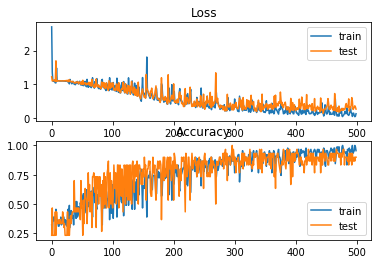

In [60]:
show_results(history)

 8 percent of label 1 predicted wrong.
33 percent of label 2 predicted wrong.
 0 percent of label 3 predicted wrong.


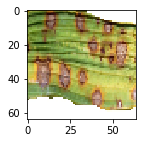

WRONG. Predicted value: [0. 0. 1.]. Label value: [0. 1. 0.]


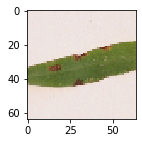

WRONG. Predicted value: [0. 0. 1.]. Label value: [0. 1. 0.]


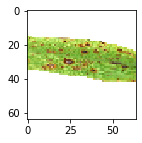

WRONG. Predicted value: [0. 0. 1.]. Label value: [0. 1. 0.]


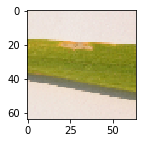

WRONG. Predicted value: [0. 1. 0.]. Label value: [1. 0. 0.]


In [14]:
y_predict = predictions(X_test)

In [65]:
predright,predwrong, ir, iw = 0, 0, 0, 0
d = np.zeros((X_test.shape[0],1))

for i in range(X_test.shape[0]):
    pred = model.predict(X_test[i].reshape((1,64,64,3)))
    d[i,:] = pred.max()
    
    if y_test[i,np.argmax(pred)] == 1:
        predright += d[i,:]
        ir += 1
        avr = predright / ir
    else:
        predwrong += d[i,:]
        iw += 1
        avw = predwrong/iw
        
print('Average score of {} right predictions: {}'.format(ir, avr))
print('Average score of {} wrong predictions: {}'.format(iw, avw))
    

Average score of 27 right predictions: [0.9186864]
Average score of 3 wrong predictions: [0.75416597]
